### Heart Attack Analyisis - TensorFlow

We want to be abble to predict if a person is vulnerable for being affected with heart attack or not using the Kaggle dataset.

* [Dataset](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

### Data Preperation
* We are targeting the output if it is a `1` or `0` which means `true` or `false` respectively.
* Other `13` columns are features.

In [2]:
data = pd.read_csv('data/heart.csv')
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### `ColumnTransformer`
* This handy `sklearn` will helps us to preprocess our data.
* We are going to transform our columns using 
    * `OneHotEncoder`
    * `MinMaxScaler`

In [11]:
data.isnull().values.any()

False

> we dont have `null` or `nan` values in our dataset. So we are ready to do the transformation on our data

In [17]:
features = data.drop(["output"], axis=1)
labels = data.iloc[:, -1].values

In [19]:
features.head(1)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1


In [22]:
len(features.columns)

13

In [23]:
column_transformer = ColumnTransformer([
    ('min_max_scaler', MinMaxScaler(), ["age", "trtbps", "chol", "thalachh", "oldpeak"]),
    ('one_hot_encoder', OneHotEncoder(), ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'])
])
column_transformer.fit(features)

ColumnTransformer(transformers=[('min_max_scaler', MinMaxScaler(),
                                 ['age', 'trtbps', 'chol', 'thalachh',
                                  'oldpeak']),
                                ('one_hot_encoder', OneHotEncoder(),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp',
                                  'caa', 'thall'])])

In [25]:
transformed_features = column_transformer.transform(features)

In [26]:
transformed_features.shape

(303, 30)

### Splitting the data into training and testing

In [28]:
X_train, X_test, y_train, y_test = train_test_split(transformed_features, labels, test_size=.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape

((242, 30), (242,), (61, 30))

### Converting the data into `tf.tensors`

In [35]:
X_train_tensors = tf.convert_to_tensor(X_train, dtype='float32')
X_test_tensors = tf.convert_to_tensor(X_test, dtype='float32')

y_train_tensors = tf.convert_to_tensor(y_train, dtype='int32')
y_test_tensors = tf.convert_to_tensor(y_test, dtype='int32')

### Creating a `Subclassing` `NN`.

In [111]:
class Net(keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.dense_1 = keras.layers.Dense(512, activation="relu", batch_input_shape=(None, 30, ))
        self.dense_2 = keras.layers.Dense(128, activation="relu")
        self.dense_3 = keras.layers.Dense(1, activation="sigmoid")
        
    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)
    
    def model(self):
        x = keras.layers.Input(30)
        return keras.Model(inputs=[x], outputs=self.call(x), name="fn_model")

In [112]:
hear_attack_nn = Net()
hear_attack_nn.model().summary()

Model: "fn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               15872     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 129       
Total params: 81,665
Trainable params: 81,665
Non-trainable params: 0
_________________________________________________________________


### Trainning the model.

In [113]:
hear_attack_nn.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer = keras.optimizers.SGD(),
    metrics = ["acc"]
)

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, mode='auto'
)

history = hear_attack_nn.fit(
    x = X_train_tensors,
    y = y_train_tensors,
    validation_data = (X_test_tensors, y_test_tensors),
    verbose = 1,
    epochs = 100,
    batch_size = 8,
    shuffle=True,
    callbacks =[lr_reduction, early_stopping]
)

Epoch 1/100
31/31 [==============================] - 1s 19ms/step - loss: 0.6766 - acc: 0.5169 - val_loss: 0.6294 - val_acc: 0.7377
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.6216 - acc: 0.6923 - val_loss: 0.5836 - val_acc: 0.8361
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 0.5689 - acc: 0.7802 - val_loss: 0.5429 - val_acc: 0.8525
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.5473 - acc: 0.7790 - val_loss: 0.5069 - val_acc: 0.8525
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4880 - acc: 0.8560 - val_loss: 0.4741 - val_acc: 0.8689
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.4920 - acc: 0.7928 - val_loss: 0.4472 - val_acc: 0.8525
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4661 - acc: 0.7912 - val_loss: 0.4235 - val_acc: 0.8525
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4363 - 

### Plotting the model trainning history

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

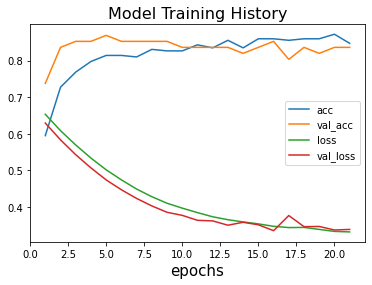

In [116]:
df = pd.DataFrame(history.history)
epochs = np.arange(1, 22)
plt.plot(epochs,df["acc"], label="acc")
plt.plot(epochs,df["val_acc"], label="val_acc")
plt.plot(epochs,df["loss"], label="loss")
plt.plot(epochs,df["val_loss"], label="val_loss")
plt.title("Model Training History", fontsize=16)
plt.legend()
plt.xlabel("epochs", fontsize=15)
plt.show()

### Making predtictions

In [99]:
predictions = tf.cast(tf.squeeze(tf.round(hear_attack_nn.predict(X_test_tensors))), dtype="int32")

In [100]:
predictions, y_test_tensors

(<tf.Tensor: shape=(61,), dtype=int32, numpy=
 array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])>,
 <tf.Tensor: shape=(61,), dtype=int32, numpy=
 array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])>)

### Confusion matrix.

In [109]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
from matplotlib import pyplot as plt

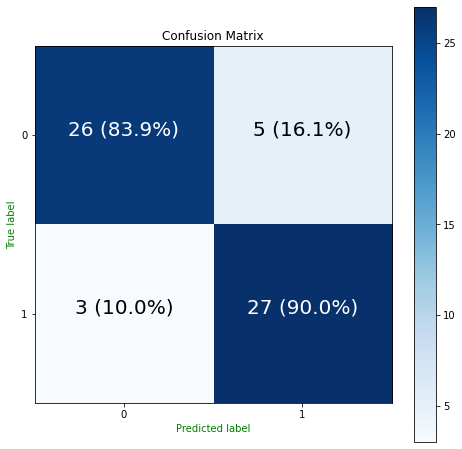

In [110]:
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=20): 
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0]
  
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) 
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels,
          )
    ax.yaxis.label.set_color('green')
    ax.xaxis.label.set_color('green')

    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)
        
plot_confusion_matrix(predictions, y_test_tensors, figsize=(8, 8))